# Lesson 4: Geospatial Data and Mapping in Python

Today we're going to learn about using geospatial data in Python. Our focus will be on using the GeoPandas package: a package that handles geospatial in familiar Pandas objects like DataFrames and Series. 

We will learn how to pull geospatial data into our Python environment, create geographies, make geospatial joins, and map geospatial data. 

Geospatial data, sometimes called GIS data, is any data which is mapped onto the globe. The most common GIS data typically works with lattitudes and longitudes, but it can also include altitudes and sometimes other geographic information. Indeed, GIS stands for Geographic Information System, and so can generically refer to anything.

## Exercise 1
Let's start off by importing our typical suite of packages: Pandas, NumPy, and Matplotlib and setting our working directory.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exercise 2
Now let's try importing GeoPandas (geopandas) with the alias gpd.

In [3]:
pip install geopandas

SyntaxError: invalid syntax (<ipython-input-3-98c305dab80c>, line 1)

You probably received a message saying that you don't have the module 'geopandas'. So, let's go ahead and install geopandas into our Python environment.

## Exercise 3
Use the following command to install GeoPandas into your Python environment: conda install -c conda-forge geopandas.

Now try importing GeoPandas again.

In [8]:
import geopandas as gpd

Great! Geospatial data comes in Shapefiles. GeoPandas will allow us to pull Shapefiles into our Python environment. However, Shapefiles aren't as simple as CSVs. Instead, they require other files to help define the geographic information it contains. Therefore, we have to download Shapefiles in ZIP folders containing all the different files we need.

## Exercise 4
Download the 2012 Ward data from the DC Open Data portal to your working directory, and extract all the files.

Now we'll use GeoPandas to pull the Shapefile into our notebook as a GeoDataFrame.

In [28]:
wards = gpd.read_file('Ward_from_2012.shp', crs='EPSG:4326')
wards.head().T

,0,1,2,3,4
OBJECTID,1,2,3,4,5
WARD,8,6,7,2,1
NAME,Ward 8,Ward 6,Ward 7,Ward 2,Ward 1
REP_NAME,"Trayon White, Sr.",Charles Allen,Vincent Gray,Jack Evans,Brianne Nadeau
WEB_URL,http://dccouncil.us/council/trayon-white-sr,http://dccouncil.us/council/charles-allen,http://dccouncil.us/council/vincent-gray,http://dccouncil.us/council/jack-evans,http://dccouncil.us/council/brianne-nadeau
REP_PHONE,(202) 724-8045,(202) 724-8072,(202) 724-8068,(202) 724-8058,(202) 724-8181
REP_EMAIL,twhite@dccouncil.us,callen@dccouncil.us,vgray@dccouncil.us,jevans@dccouncil.us,bnadeau@dccouncil.us
REP_OFFICE,"1350 Pennsylvania Ave, Suite 400, NW 20004","1350 Pennsylvania Ave, Suite 406, NW 20004","1350 Pennsylvania Ave, Suite 406, NW 20004","1350 Pennsylvania Ave, Suite 106, NW 20004","1350 Pennsylvania Ave, Suite 102, NW 20004"
WARD_ID,8,6,7,2,1
LABEL,Ward 8,Ward 6,Ward 7,Ward 2,Ward 1


Because the Earth is a not-quite-sphere but our screens are flat, it is important to remember that working with geospatial data that it always consists of two parts: a projection (or coordinate reference system) and a collection of geometries.

The most common projection of geospatial data you'll see is WGS84 (World Geodetic System 1984) which affixes to every point on the Earth a latitude an longitude. In other words, it is a Mercator projection. EPSG:4326 is WSG84 in EPSG language. The vast majority (all?) of DC data is based on the Master Address Repository (or MAR), which lists things in latitudes and longitudes in the WGS84 projection. Be warned when working with these sorts of files that you will potentially run into issues near the poles with Mercator projections, but they should be generally fine around DC.

As for geometries, there are essentially three major building blocks: points, lines, and polygons. All GIS operations are defined for all three types (as well as combinations of all three types), but be warned that the behavior of, say, asking for the centroid of a point and a polygon may not behave as you expect. Each GeoPandas dataframe has a geometry that is either a polygon, line, or point.

Let's take a look at the geometry column in our GeoPandas dataframe of the District's wards.

In [29]:
wards.geometry

0    POLYGON ((-76.97042036116309 38.86354140270933...
1    POLYGON ((-77.01811124250071 38.91465349490675...
2    POLYGON ((-76.96177462268585 38.85194203844998...
3    POLYGON ((-77.02703742951195 38.91409764942713...
4    POLYGON ((-77.01903517175128 38.93740601587856...
5    POLYGON ((-76.94186181138446 38.91854306335237...
6    POLYGON ((-77.04829948305917 38.93481198746282...
7    POLYGON ((-76.99143503979559 38.95730353605698...
Name: geometry, dtype: object

Now let's plot the geometries.

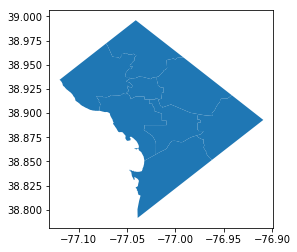

In [45]:
wards.geometry.plot()

We can also create geometries from Pandas dataframes that have longitude and latitude. Let's do this with our 311 data from 2016.

## Exercise 5
Import the city service requests from 2016 that we've been using.

In [37]:
%ddir

 Volume in drive C is Windows
 Volume Serial Number is 7489-C010

 Directory of C:\Users\Michael\Desktop

09/21/2017  06:57 PM    <DIR>          .
09/21/2017  06:57 PM    <DIR>          ..
09/21/2017  06:19 PM    <DIR>          .ipynb_checkpoints
09/17/2017  10:47 PM    <DIR>          2016-17
09/21/2017  06:53 PM    <DIR>          DataScience
08/13/2017  09:47 AM    <DIR>          DesktopOLD
09/07/2017  06:25 PM    <DIR>          GradSchool
07/19/2017  01:31 AM    <DIR>          Job Stuff
09/06/2017  12:31 AM    <DIR>          Photos070715
05/26/2017  01:33 PM    <DIR>          Writing Samples
               0 File(s)              0 bytes
              10 Dir(s)  892,491,141,120 bytes free


In [43]:
df = pd.read_csv('https://opendata.arcgis.com/datasets/0e4b7d3a83b94a178b3d1f015db901ee_7.csv')

There are lots of service requests in the city each year, so let's focus in on just one. Perhaps one in which I have a little expertise...

## Exercise 6
Create a new dataframe called 'rats' from just the city service requests with the service code description 'Rodent Inspection and Treatment' from August 2016.

In [68]:
df['request_date'] = pd.to_datetime(df['SERVICEORDERDATE'])
aug_requests = df[df.request_date.dt.month==8]
rats = aug_requests[aug_requests.SERVICECODEDESCRIPTION=='Rodent Inspection and Treatment']

We can use the longitude and latitude columns to create a geometry for this data. 

For this we need to import Point function from the shapely package.

In [61]:
df

,X,Y,OBJECTID,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODEDESCRIPTION,ORGANIZATIONACRONYM,SERVICECALLCOUNT,ADDDATE,RESOLUTIONDATE,...,YCOORD,LATITUDE,LONGITUDE,CITY,STATE,ZIPCODE,MARADDRESSREPOSITORYID,WARD,DETAILS,request_date
0,-77.068472,38.959221,928367,EMNPV,Emergency No-Parking Verification,PEMA- Parking Enforcement Management Administr...,DPW,1,2016-01-04T16:45:21.000Z,2016-01-04T21:13:04.000Z,...,143480.700000,38.959214,-77.068470,WASHINGTON,DC,20015.0,262895.0,3.0,NaN,2016-01-04 16:45:21
1,-77.028858,38.903745,947826,S0276,Parking Meter Repair,Transportation Operations Administration,DDOT,1,2016-05-02T11:43:31.000Z,2016-05-03T01:38:10.000Z,...,137320.600003,38.903738,-77.028856,WASHINGTON,DC,20005.0,812754.0,2.0,Need More Information,2016-05-02 11:43:31
2,-77.019418,38.941567,947827,S0361,Sidewalk Repair,Toa-Street & Bridge Maintenance,DDOT,1,2016-05-02T11:47:49.000Z,NaN,...,141518.950000,38.941560,-77.019416,WASHINGTON,DC,20011.0,247564.0,4.0,NaN,2016-05-02 11:47:49
3,-77.014655,38.906236,947828,PRUNING,Tree Pruning,Urban Forrestry,DDOT,1,2016-05-02T10:44:23.000Z,2017-01-19T11:03:08.000Z,...,137596.790000,38.906229,-77.014652,WASHINGTON,DC,20001.0,238344.0,6.0,"By BANUA, SIMOUN: 5/2/2016 12:48:15 PM\nthis t...",2016-05-02 10:44:23
4,-77.004008,38.835935,947829,S0031,Bulk Collection,SWMA- Solid Waste Management Admistration,DPW,1,2016-05-02T11:49:49.000Z,2016-05-12T14:27:19.000Z,...,129792.780000,38.835928,-77.004005,WASHINGTON,DC,20032.0,66302.0,8.0,w riggans collected bulk on 5/12/16*closed by ...,2016-05-02 11:49:49
5,-77.004008,38.835935,947830,S0031,Bulk Collection,SWMA- Solid Waste Management Admistration,DPW,1,2016-05-02T11:49:50.000Z,2016-05-12T14:26:24.000Z,...,129792.780000,38.835928,-77.004005,WASHINGTON,DC,20032.0,66302.0,8.0,w riggans collected bulk on 5/12/16*closed by ...,2016-05-02 11:49:50
6,-77.020134,38.914935,986620,S0261,Parking Enforcement,PEMA- Parking Enforcement Management Administr...,DPW,1,2016-03-16T08:10:25.000Z,2016-03-16T11:01:29.000Z,...,138562.500000,38.914927,-77.020132,WASHINGTON,DC,20001.0,238452.0,6.0,NaN,2016-03-16 08:10:25
7,-77.018788,38.915155,986621,S0441,Trash Collection - Missed,SWMA- Solid Waste Management Admistration,DPW,1,2016-03-16T08:12:34.000Z,2016-03-18T11:20:03.000Z,...,138586.890000,38.915147,-77.018786,WASHINGTON,DC,20001.0,229894.0,1.0,COMPLETED BY 3/17/16 D STREET CLOSED BY NDAVALL,2016-03-16 08:12:34
8,-77.018788,38.915155,986622,S0441,Trash Collection - Missed,SWMA- Solid Waste Management Admistration,DPW,1,2016-03-16T08:12:35.000Z,2016-03-18T11:22:49.000Z,...,138586.890000,38.915147,-77.018786,WASHINGTON,DC,20001.0,229894.0,1.0,COMPLETED BY D STREET 3/17/16 CLOSED BY NDAVALL,2016-03-16 08:12:35
9,-77.011544,38.915718,986623,S0441,Trash Collection - Missed,SWMA- Solid Waste Management Admistration,DPW,1,2016-03-16T08:10:29.000Z,2016-03-25T08:13:57.000Z,...,138649.350000,38.915711,-77.011542,WASHINGTON,DC,20001.0,300722.0,5.0,COMPLETED BY L FERGUSON 3/17/16 CLOSED BY NDA...,2016-03-16 08:10:29


In [71]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(rats.LONGITUDE.apply(float), rats.LATITUDE.apply(float))]


We now have a geometry, in this case points. But recall that you also need a projection, or crs. If we want to match these points to our ward polygons, they need to have the same coordinate system. 

In [72]:
crs = {'init': 'epsg:4326'}

Now that we have a geometry and a projection, we can combine them with the original Pandas dataframe into a new GeoPandas dataframe.

In [73]:
points = gpd.GeoDataFrame(rats, crs=crs, geometry=geometry)

Great! Now we have a new GeoPandas dataframe with points for each of the requests for rodent inspection and treatment in 2016.

We can now use this to map them on to DC. Let's try it out! 

We'll just look at requests for rodent inspection and treatment in August so the plot doesn't get too busy. 

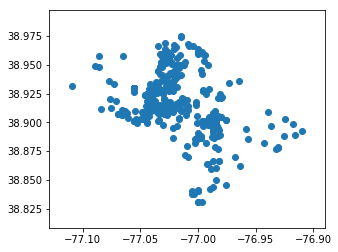

In [77]:
points['Date'] = pd.to_datetime(rats['SERVICEORDERDATE'])
points[points.Date.dt.month==8].geometry.plot()

Neat! We can kind of see the outline of the District, but it would be even better to plot it ONTO the wards. Let's try that out.

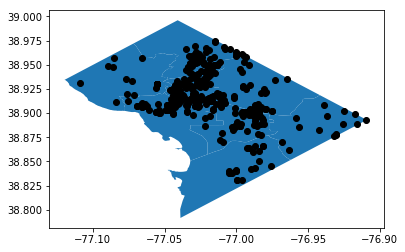

In [85]:
fig, ax = plt.subplots()
wards.plot(ax=ax)
points[points.Date.dt.month==8].plot(ax=ax, color='black')

Ugh! What's with the weird shape? Turns out we have to fix the figure's aspect ratio.

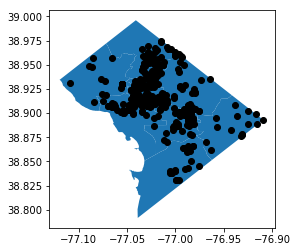

In [86]:
fig, ax = plt.subplots()
wards.plot(ax=ax)
points[points.Date.dt.month==8].plot(ax=ax, color='black')
ax.set_aspect('equal')

Much better but we can improve the map some by making it bigger, making the polygons white and the points translucent.

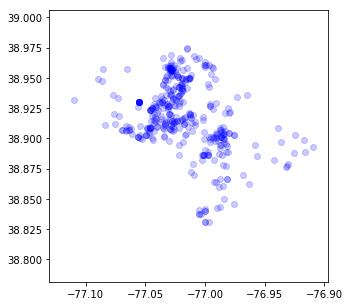

In [87]:
fig, ax = plt.subplots(figsize=(5,5))
wards.plot(ax=ax, color='white')
points[points.Date.dt.month==8].plot(ax=ax, color='blue', alpha=0.2)

Now we're talking! But what if we want to get the number of requests for rodent inspection and treatment in each ward? And what if want to map the wards based on such an aggregate?

We can also use SPATIAL JOINS to join the points we created to our ward polygons.

Joins and merges are something we'll be doing a LOT of over the course of the semester. These are crucial for pulling together data from disparate sources. Often, joins and merges are based on the values of a column that two dataframes have in common. In fact, there's an "easy way" that we could combine this data by merging based on the WARD in each dataframe using the Pandas merge function.

In [88]:
ward_rats = wards.merge(points, how='left', on='WARD')
ward_rats.head().T

,0,1,2,3,4
OBJECTID_x,1,1,1,1,1
WARD,8,8,8,8,8
NAME,Ward 8,Ward 8,Ward 8,Ward 8,Ward 8
REP_NAME,"Trayon White, Sr.","Trayon White, Sr.","Trayon White, Sr.","Trayon White, Sr.","Trayon White, Sr."
WEB_URL,http://dccouncil.us/council/trayon-white-sr,http://dccouncil.us/council/trayon-white-sr,http://dccouncil.us/council/trayon-white-sr,http://dccouncil.us/council/trayon-white-sr,http://dccouncil.us/council/trayon-white-sr
REP_PHONE,(202) 724-8045,(202) 724-8045,(202) 724-8045,(202) 724-8045,(202) 724-8045
REP_EMAIL,twhite@dccouncil.us,twhite@dccouncil.us,twhite@dccouncil.us,twhite@dccouncil.us,twhite@dccouncil.us
REP_OFFICE,"1350 Pennsylvania Ave, Suite 400, NW 20004","1350 Pennsylvania Ave, Suite 400, NW 20004","1350 Pennsylvania Ave, Suite 400, NW 20004","1350 Pennsylvania Ave, Suite 400, NW 20004","1350 Pennsylvania Ave, Suite 400, NW 20004"
WARD_ID,8,8,8,8,8
LABEL,Ward 8,Ward 8,Ward 8,Ward 8,Ward 8


Our data is merged, but there are problems with such a merge. Such a merge creates a Pandas dataframe rather than a GeoPandas dataframe, so it does not preserve our geometry. We can recreate the geometry, but for the sake of this lesson, let's focus instead on the spatial join, since this will be necessary when a common column like 'WARD' is not available.

In [ ]:
geo_rats = gpd.sjoin(wards, points, how='left', op='intersects')

Let's dissect this. The 'how' parameter refers to the type of join. A 'left' join preserves the rows on the left. For example, if there were no requests for rodent inspection and treatment in Ward 7, this join would still include Ward 7 in the list of wards. The 'op' command tells us what relationship to look for between the geometries of the two GeoPandas dataframes. It does not matter what 'op' we choose for a points-to-polygons join, but it will matter when we join polygons. 

Now, let's take a look at the geometry of the new dataframe.

In [ ]:
geo_rats.geometry.head()

It's a polygon! Let's map it!

In [ ]:
geo_rats.geometry.plot()

Oh no! That doesn't help us at all! How do we create a useful plot?

First, let's create an informative aggregate, like the percent of rat calls citywide that are in each ward. We'll do this by get a count of the number of requests in each ward and then dividing it by the total number of requests.

In [ ]:
geo_rats.WARD.value_counts/rats.shape[0]

Oops! What went wrong?

Take a look at the columns. When we do a join and the two dataframes each has a column of the same name (such as "WARD"), then the function will add a suffix to each. In this case, "left" and "right". Let's try it again. 

In [ ]:
geo_rats.WARD_left.value_counts()/geo_rats.shape[0]

As I mentioned before, this provides us with an index and a column of values, so we can actually make this into a DataFrame.

In [ ]:
rats_pcttot = pd.DataFrame(geo_rats.WARD_left.value_counts()/geo_rats.shape[0])
rats_pcttot.columns = ['rats_pcttot']
rats_pcttot

Now we can merge this to the wards GeoDataFrame and map it.

In [ ]:
ward_rats = wards.merge(rats_pcttot, how="left", left_on='WARD', right_index=True)
ward_rats.head().T

Now we can create a heat map.

In [ ]:
ward_rats.plot(column='rats_pcttot', cmap='YlOrRd')

We can also create a color bar to help us interpret the heatmap.

In [ ]:
vmin = ward_rats.rats_pcttot.min()
vmax = ward_rats.rats_pcttot.max()

ax = ward_rats.plot('rats_pcttot', cmap='YlOrRd', vmin=vmin, vmax=vmax)

fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)

## Exercise 7
Now that we've shown the distribution of requests for rodent inspection and treatment across wards, let's look at Advisory Neighborhood Commissions, or ANCs. Each of DC's seven wards is divided into ANCs that deal with neighborhood needs at an even more local levels. Find the 2013 ANC's on the Open Data Portal, download and extract the Shapefile and pull it into the notebook as a GeoPandas dataframe. Then join city service requests to this GeoDataFrame. You may use whichever requests you'd like to explore. Create aggregates and maps like the ones we created above, and let's share them in class. Enjoy!